<a href="https://colab.research.google.com/github/YifanYyds/Deep_Learning_Final/blob/main/SimpleRNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/train_df.csv", header=0, delimiter=",")
val_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/val_df.csv", header=0, delimiter=",")
test_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/test_df.csv", header=0, delimiter=",")


Mounted at /content/drive


In [2]:
import shutil
import os

# Check if the directory exists
if os.path.exists('my_dir/keras_simple_rnn_tuning'):
    # If it exists, delete it
    shutil.rmtree('my_dir/keras_simple_rnn_tuning')


In [3]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.callbacks import EarlyStopping

# Prepare the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

# Ensure all text data is string and handle missing values
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Convert texts to sequences
train_seq = tokenizer.texts_to_sequences(train_df['text'])
val_seq = tokenizer.texts_to_sequences(val_df['text'])
test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
max_length = max(max(len(x) for x in train_seq), max(len(x) for x in val_seq), max(len(x) for x in test_seq))
train_seq_padded = pad_sequences(train_seq, maxlen=max_length)
val_seq_padded = pad_sequences(val_seq, maxlen=max_length)
test_seq_padded = pad_sequences(test_seq, maxlen=max_length)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_df['label'])
val_labels = to_categorical(val_df['label'])
test_labels = to_categorical(test_df['label'])


In [5]:
import numpy as np

# Find the indices for each category
negative_indices = np.where(np.argmax(test_labels, axis=1) == 0)[0]
neutral_indices = np.where(np.argmax(test_labels, axis=1) == 1)[0]
positive_indices = np.where(np.argmax(test_labels, axis=1) == 2)[0]

# Extract sequences for each category using the indices
negative_test_seq_padded = test_seq_padded[negative_indices]
neutral_test_seq_padded = test_seq_padded[neutral_indices]
positive_test_seq_padded = test_seq_padded[positive_indices]

# Extract the corresponding labels
negative_test_labels = test_labels[negative_indices]
neutral_test_labels = test_labels[neutral_indices]
positive_test_labels = test_labels[positive_indices]

In [6]:
# Check Shapes
print(f"Total test samples: {test_seq_padded.shape[0]}")
print(f"Negative samples: {negative_test_seq_padded.shape[0]}")
print(f"Neutral samples: {neutral_test_seq_padded.shape[0]}")
print(f"Positive samples: {positive_test_seq_padded.shape[0]}")

# Check that the sum of subset sizes equals the total
assert test_seq_padded.shape[0] == (negative_test_seq_padded.shape[0] +
                                    neutral_test_seq_padded.shape[0] +
                                    positive_test_seq_padded.shape[0]), "Counts do not match."

# Check Label Distribution
# This should only output the corresponding label for each subset
print(f"Unique labels in negative subset: {np.unique(np.argmax(negative_test_labels, axis=1))}")
print(f"Unique labels in neutral subset: {np.unique(np.argmax(neutral_test_labels, axis=1))}")
print(f"Unique labels in positive subset: {np.unique(np.argmax(positive_test_labels, axis=1))}")

# Inspect Individual Samples (randomly)
for i in np.random.choice(negative_indices, 5, replace=False):
    print(f"Sample text: {test_df.iloc[i]['text']} - Label: {test_df.iloc[i]['label']} (Expected: 0)")


Total test samples: 5206
Negative samples: 1546
Neutral samples: 1930
Positive samples: 1730
Unique labels in negative subset: [0]
Unique labels in neutral subset: [1]
Unique labels in positive subset: [2]
Sample text: _2890 Nt able to follow anyone  friendorfollow.com here i come!!! #itsucks - Label: 0 (Expected: 0)
Sample text: Just installed. Keyed in all tasks n to-do list. Server error. Lost everything. Redo. Server error. Lost. Kept repeating. Frustrating = Uninstalled. - Label: 0 (Expected: 0)
Sample text: Oh no... that bird is back - Label: 0 (Expected: 0)
Sample text:  copy & paste **** **** tosser piss flap a 10000000000 times !!!! - Label: 0 (Expected: 0)
Sample text: I couldn't understand it probably my fault but I find it complicate and I like to organize my day like without go and add on my calender just on this app but like I said it's probably my fault / gonna try this app again later maybe like after couple of different updates - Label: 0 (Expected: 0)


In [7]:
import time
from keras.callbacks import Callback
global_epoch_times = []

class TimeHistory(Callback):
    def __init__(self):
        super(TimeHistory, self).__init__()
        self.times = []

    def on_train_batch_begin(self, batch, logs=None):
        self.batch_time_start = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.times.append(time.time() - self.batch_time_start)

    def on_epoch_end(self, epoch, logs=None):
        average_time_per_batch = sum(self.times) / len(self.times)
        global_epoch_times.append(average_time_per_batch)  # Append to the global list
        self.times = []  # Reset for the next epoch


In [8]:
import keras_tuner as kt
# Model builder function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=128, step=32), input_length=max_length))
    model.add(SimpleRNN(units=hp.Int('rnn_units', min_value=128, max_value=256, step=64)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,  # Number of trials to run
    factor=3,  # Number of models to train per trial
    directory='my_dir',  # Directory to store the tuning logs
    project_name='keras_simple_rnn_tuning'
)

# Instantiate the callbacks
time_history = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

tuner.search(train_seq_padded, train_labels,
             epochs=10,
             validation_data=(val_seq_padded, val_labels),
             callbacks=[early_stopping, time_history])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('rnn_units')} and the optimal output dimension of the Embedding layer is {best_hps.get('embedding_output_dim')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.fit(train_seq_padded, train_labels, epochs=10, validation_data=(val_seq_padded, val_labels),callbacks=[early_stopping, time_history],batch_size=512)

# Evaluate the model
loss, accuracy = model.evaluate(test_seq_padded, test_labels)
print(f'Test Accuracy: {accuracy:.4f}')

Trial 9 Complete [00h 10m 23s]
val_accuracy: 0.599807858467102

Best val_accuracy So Far: 0.6461095213890076
Total elapsed time: 01h 37m 24s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal output dimension of the Embedding layer is 96.

Epoch 1/10
61/61 [==============================] - 30s 475ms/step - loss: 1.0786 - accuracy: 0.4102 - val_loss: 1.0453 - val_accuracy: 0.4815
Epoch 2/10
61/61 [==============================] - 27s 447ms/step - loss: 0.8712 - accuracy: 0.6602 - val_loss: 0.9026 - val_accuracy: 0.5779
Epoch 3/10
61/61 [==============================] - 25s 414ms/step - loss: 0.5877 - accuracy: 0.7963 - val_loss: 1.5455 - val_accuracy: 0.4866
Epoch 4/10
61/61 [==============================] - 22s 365ms/step - loss: 0.8519 - accuracy: 0.6382 - val_loss: 0.9910 - val_accuracy: 0.4782
Epoch 5/10
61/61 [==============================] - 24s 390ms/step - loss: 0.7623 - accuracy: 0.6969 - val_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


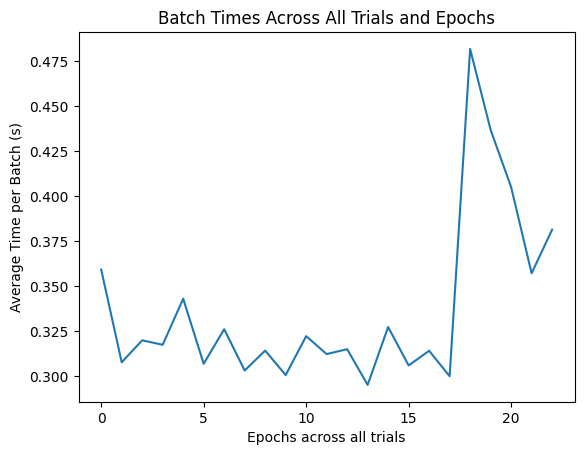

In [9]:
import matplotlib.pyplot as plt

plt.plot(global_epoch_times)
plt.xlabel('Epochs across all trials')
plt.ylabel('Average Time per Batch (s)')
plt.title('Batch Times Across All Trials and Epochs')
# Save the plot to the Colab VM
plt.savefig('rnn_batch_times.png')

# If using Google Colab and want to save it to Google Drive
from google.colab import drive
drive.mount('/content/drive')
plot_path = '/content/drive/My Drive/best_model_final_project/rnn_batch_times.png'
plt.savefig(plot_path)
plt.show()


In [10]:
import pickle

# Serialize and save the variable to a file
with open('/content/drive/My Drive/best_model_final_project/rnn_global_epoch_times.pkl', 'wb') as f:
    pickle.dump(global_epoch_times, f)


In [11]:
loss, accuracy = model.evaluate(test_seq_padded, test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


163/163 [==============================] - 7s 41ms/step - loss: 1.0295 - accuracy: 0.4908
Test Loss: 1.0295
Test Accuracy: 0.4908


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Predict the test set
predictions = model.predict(test_seq_padded)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate additional metrics
print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))


163/163 [==============================] - 5s 31ms/step
              precision    recall  f1-score   support

           0       0.79      0.13      0.23      1546
           1       0.42      0.92      0.58      1930
           2       0.78      0.34      0.47      1730

    accuracy                           0.49      5206
   macro avg       0.67      0.46      0.42      5206
weighted avg       0.65      0.49      0.44      5206

[[ 204 1297   45]
 [  43 1771  116]
 [  10 1140  580]]


In [13]:
# Evaluate the model on the negative subset
negative_loss, negative_accuracy = model.evaluate(negative_test_seq_padded, negative_test_labels)
print(f'Negative Test Accuracy: {negative_accuracy:.4f}')

# Evaluate the model on the neutral subset
neutral_loss, neutral_accuracy = model.evaluate(neutral_test_seq_padded, neutral_test_labels)
print(f'Neutral Test Accuracy: {neutral_accuracy:.4f}')

# Evaluate the model on the positive subset
positive_loss, positive_accuracy = model.evaluate(positive_test_seq_padded, positive_test_labels)
print(f'Positive Test Accuracy: {positive_accuracy:.4f}')


49/49 [==============================] - 2s 44ms/step - loss: 1.4285 - accuracy: 0.1320
Negative Test Accuracy: 0.1320
61/61 [==============================] - 3s 46ms/step - loss: 0.4897 - accuracy: 0.9176
Neutral Test Accuracy: 0.9176
55/55 [==============================] - 2s 32ms/step - loss: 1.2751 - accuracy: 0.3353
Positive Test Accuracy: 0.3353


In [14]:
from sklearn.metrics import classification_report

# Predict on each subset
negative_predictions = model.predict(negative_test_seq_padded)
neutral_predictions = model.predict(neutral_test_seq_padded)
positive_predictions = model.predict(positive_test_seq_padded)

# Convert predictions to discrete labels
negative_predicted_labels = np.argmax(negative_predictions, axis=1)
neutral_predicted_labels = np.argmax(neutral_predictions, axis=1)
positive_predicted_labels = np.argmax(positive_predictions, axis=1)

# Calculate classification report for each
print('Classification Report for Negative Subset:')
print(classification_report(np.argmax(negative_test_labels, axis=1), negative_predicted_labels))

print('Classification Report for Neutral Subset:')
print(classification_report(np.argmax(neutral_test_labels, axis=1), neutral_predicted_labels))

print('Classification Report for Positive Subset:')
print(classification_report(np.argmax(positive_test_labels, axis=1), positive_predicted_labels))


55/55 [==============================] - 2s 30ms/step
Classification Report for Negative Subset:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23      1546
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.13      1546
   macro avg       0.33      0.04      0.08      1546
weighted avg       1.00      0.13      0.23      1546

Classification Report for Neutral Subset:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96      1930
           2       0.00      0.00      0.00         0

    accuracy                           0.92      1930
   macro avg       0.33      0.31      0.32      1930
weighted avg       1.00      0.92      0.96      1930

Classification Report for Positive Subset:
              precision    recall  f1-score   support

 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [15]:
# Save the entire model to a file
model.save('my_rnn_model.h5')  # Saves to the Colab VM

# If using Google Colab, save it to Google Drive by mounting the drive first
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/best_model_final_project/my_rnn_model.h5'
model.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
